In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.04 and 0.8 repectively. While the former is equal to the paramterization considered in Archambeau et al 2007, the latter is higher (0.8 vs 0.5)

m(t) = $\alpha$t + $m_{0}$

Noisy Observations from the SDE:

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

**Generate observations from Gaussian likelihood**

In [19]:
# Time step the SDE: dot X = -mu X + sigma xi, by Euler's method.

# Problem setup. 
# Set model and numerical parameters, and the initial condition.
# These are the lines the user might want to vary.
tf = 8
Nsteps = 800
Npaths = 1
X0 = 1
sde_sigma = 0.7 # Variance is higher than the original example
obs_sigma = 0.04

# Generate the time grid and solution array
t, dt = np.linspace(0,tf,Nsteps+1,retstep=True)
X = np.zeros((Nsteps+1,Npaths))
root_dt = np.sqrt(dt)
  
# Time step starting from initial condition
X[0,:] = X0;
for n in range(Nsteps):
    F_of_X = 4 * X[n,:] * (1 - (X[n,:] ** 2))
    X[n+1,:] =  X[n,:] + dt * F_of_X + sde_sigma * root_dt * np.random.randn(Npaths)

# Observations with Gaussian noise
obs = np.random.normal(loc = X[::100], scale = obs_sigma)
obs_time = t[::100]

Change dtype

In [20]:
true_sde_pts = torch.from_numpy(t)
true_sde_trj = torch.from_numpy(X.flatten())

In [21]:
obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

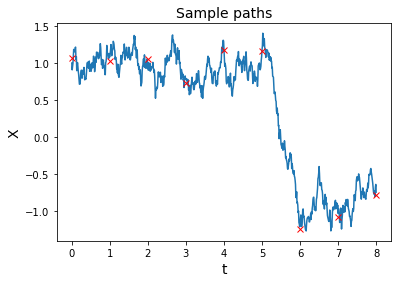

In [22]:
# Plot paths
plt.plot(t,X)
plt.plot(t[::100], obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


In [23]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

**Class: OU processes**

In [24]:
class tOU_vector:
    """
        simulate multiple trajectories at one-go via vectorisation;
        
    """
    
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN, D, timegrid = 'True'):
        """
        
        """
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        """
            # of trajectories you wish to sample
        """
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
#             self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0].repeat(D,1)
        self.trj, self.dt = self.simulate()

    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
            outcome
                D by N matrices whose row corresponds to one independent time-dependent OU process
        """
        output = torch.empty(self.pts.shape)
        output[:,0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        beta_t = self.alpha * ((( self.pts[:, :-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[:, 1:] + 1)**self.beta) - 1) + self.m0)
        for t in range(1, self.pts.shape[1]):
            # if the distance is too small, variance becomes 0
            mean = (output[:, t-1] - beta_t[:, t-1]) * torch.exp(-1 * self.r.flatten() * interval[:, t-1] )
            var = ((self.sigma ** 2 ) / (2*self.r.flatten())) * (1 - torch.exp(-2 * self.r.flatten() * interval[:, t-1]))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean, cov = torch.diag(var)))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
            
        return [output, interval]

Variational inference: KL

In [25]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: 16 * (z**6) - 32 * (z**4) + (16-(r**2))*(z**2) \
                - 2*r*alpha*beta*z*(B(s, beta-1) - (beta - 1) * B(s, beta-2)) - 12 * (sigma ** 2) * (z ** 2) \
                + (2*r*z + r*alpha*(B(s, beta) - 1) + r*m0 + alpha*beta*B(s, beta-1)) * (r * alpha * (B(s, beta) - 1) + r*m0 + \
                                                                                alpha * beta * B(s, beta-1))
        
        num = func(self.ou.pts, self.ou.trj)

        return -0.5 * torch.trapezoid(num, x=self.ou.pts).reshape(-1, 1) / (sigma ** 2)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = self.ou.D
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        t0 = self.ou.t0.clone().detach().repeat(D, 1)
        t1 = self.ou.t1.clone().detach().repeat(D, 1)
        
        # Obtain the rest 
        def A(s, u):
            return (-1 * (u ** 4) + (4+r)*(u ** 2)/2 - u*r*(alpha*((s+1) ** beta - 1) + m0 - alpha*beta*((s+1) ** (beta-1))))
            
        
        return (A(t1, z1) - A(t0, z0)) / (sigma ** 2) - 0.5 * (t1 - t0) * (r+4)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


In [26]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = False)
        m0 = Variable(m0, requires_grad = True)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'m0':m0.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [27]:
import tqdm as tq

In [38]:
D = 30

alpha_ = torch.tensor([0.])
r_ = torch.tensor([0.5])
m0_ = torch.tensor([0.])
beta_D = torch.tensor([1.]).repeat(D,1)
z0 = obs[0].repeat(D,1)

learning_rate = 0.001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(150)):
    alpha_D = alpha_.repeat(D, 1)
    r_D = r_.repeat(D, 1)
    m0_D = m0_.repeat(D, 1)
    # Compute (negative) ELBO
    vi_ = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=z0, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo_ = ELBO(vi_)
    elbo_estimate = -1 * (elbo_.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo_.KL_ito() + elbo_.KL_rest())
    

    trace_pars.append((m0_.clone(), alpha_.clone(), r_.clone()))
    trace_elbo.append(torch.mean(elbo_estimate))
    
    # Obtain score function estimator of the gradient
    vi = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=z0, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo = ELBO(vi)
    score = Score(vi)

    scores = score.compute_score(alpha_D, beta_D, m0_D, r_D)
    f_of_X = -1 * (elbo.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
    m0_grad = torch.mean(f_of_X * scores['m0'])
    alpha_grad = torch.mean(f_of_X * scores['alpha'])
    r_grad = torch.mean(f_of_X * scores['r'])

    # Update the parameter
    m0_ -= learning_rate * m0_grad
    alpha_ -= learning_rate * alpha_grad
    r__ = r_ - learning_rate * r_grad
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ - lr * r_grad
        lr *= 0.5
    r_ = r__
    
    print("m0 = ", m0_, "alpha = ", alpha_, "r = ", r_, '(Negative) ELBO = ', torch.mean(elbo_estimate))
    
    
# score.compute_score()

  4%|█▋                                         | 6/150 [00:00<00:02, 53.27it/s]

m0 =  tensor([0.1470]) alpha =  tensor([0.3831]) r =  tensor([0.3557]) (Negative) ELBO =  tensor(96.7125, dtype=torch.float64)
m0 =  tensor([0.0725]) alpha =  tensor([0.1436]) r =  tensor([0.6416]) (Negative) ELBO =  tensor(229.8411, dtype=torch.float64)
m0 =  tensor([0.2506]) alpha =  tensor([0.5248]) r =  tensor([0.6311]) (Negative) ELBO =  tensor(126.1117, dtype=torch.float64)
m0 =  tensor([0.2473]) alpha =  tensor([0.5137]) r =  tensor([0.8089]) (Negative) ELBO =  tensor(296.5419, dtype=torch.float64)
m0 =  tensor([0.1694]) alpha =  tensor([0.3757]) r =  tensor([0.8947]) (Negative) ELBO =  tensor(85.8181, dtype=torch.float64)
m0 =  tensor([0.1331]) alpha =  tensor([0.3339]) r =  tensor([0.9605]) (Negative) ELBO =  tensor(65.8373, dtype=torch.float64)
m0 =  tensor([0.1971]) alpha =  tensor([0.4514]) r =  tensor([0.9909]) (Negative) ELBO =  tensor(125.0579, dtype=torch.float64)
m0 =  tensor([-0.2589]) alpha =  tensor([-0.2628]) r =  tensor([1.6663]) (Negative) ELBO =  tensor(72.1183,

 13%|█████▌                                    | 20/150 [00:00<00:02, 59.32it/s]

m0 =  tensor([0.3502]) alpha =  tensor([0.4520]) r =  tensor([1.6363]) (Negative) ELBO =  tensor(94.4514, dtype=torch.float64)
m0 =  tensor([0.3846]) alpha =  tensor([0.4966]) r =  tensor([1.6339]) (Negative) ELBO =  tensor(48.7405, dtype=torch.float64)
m0 =  tensor([0.2632]) alpha =  tensor([0.3559]) r =  tensor([1.6879]) (Negative) ELBO =  tensor(88.1199, dtype=torch.float64)
m0 =  tensor([0.3845]) alpha =  tensor([0.5048]) r =  tensor([1.6926]) (Negative) ELBO =  tensor(72.0866, dtype=torch.float64)
m0 =  tensor([0.3807]) alpha =  tensor([0.5089]) r =  tensor([1.7196]) (Negative) ELBO =  tensor(70.7063, dtype=torch.float64)
m0 =  tensor([0.3370]) alpha =  tensor([0.4600]) r =  tensor([1.7440]) (Negative) ELBO =  tensor(45.8556, dtype=torch.float64)
m0 =  tensor([0.3465]) alpha =  tensor([0.4692]) r =  tensor([1.7730]) (Negative) ELBO =  tensor(59.9726, dtype=torch.float64)
m0 =  tensor([0.3695]) alpha =  tensor([0.4977]) r =  tensor([1.7798]) (Negative) ELBO =  tensor(43.5236, dtype

 23%|█████████▌                                | 34/150 [00:00<00:01, 60.96it/s]

m0 =  tensor([0.3005]) alpha =  tensor([0.5074]) r =  tensor([1.9296]) (Negative) ELBO =  tensor(51.9592, dtype=torch.float64)
m0 =  tensor([0.3926]) alpha =  tensor([0.6269]) r =  tensor([1.9325]) (Negative) ELBO =  tensor(25.6614, dtype=torch.float64)
m0 =  tensor([0.2308]) alpha =  tensor([0.4648]) r =  tensor([1.9806]) (Negative) ELBO =  tensor(66.8927, dtype=torch.float64)
m0 =  tensor([0.3334]) alpha =  tensor([0.5994]) r =  tensor([1.9946]) (Negative) ELBO =  tensor(56.5621, dtype=torch.float64)
m0 =  tensor([0.3692]) alpha =  tensor([0.6492]) r =  tensor([2.0007]) (Negative) ELBO =  tensor(62.2712, dtype=torch.float64)
m0 =  tensor([0.2284]) alpha =  tensor([0.4980]) r =  tensor([2.0431]) (Negative) ELBO =  tensor(26.0661, dtype=torch.float64)
m0 =  tensor([0.2666]) alpha =  tensor([0.5245]) r =  tensor([2.0381]) (Negative) ELBO =  tensor(50.8523, dtype=torch.float64)
m0 =  tensor([0.3722]) alpha =  tensor([0.6487]) r =  tensor([2.0521]) (Negative) ELBO =  tensor(52.1906, dtype

 32%|█████████████▍                            | 48/150 [00:00<00:01, 61.33it/s]

m0 =  tensor([0.2154]) alpha =  tensor([0.5374]) r =  tensor([2.2350]) (Negative) ELBO =  tensor(32.8637, dtype=torch.float64)
m0 =  tensor([0.2797]) alpha =  tensor([0.6044]) r =  tensor([2.2479]) (Negative) ELBO =  tensor(34.3931, dtype=torch.float64)
m0 =  tensor([0.2163]) alpha =  tensor([0.5251]) r =  tensor([2.2652]) (Negative) ELBO =  tensor(39.3274, dtype=torch.float64)
m0 =  tensor([0.3607]) alpha =  tensor([0.7020]) r =  tensor([2.2888]) (Negative) ELBO =  tensor(47.2251, dtype=torch.float64)
m0 =  tensor([0.3901]) alpha =  tensor([0.7003]) r =  tensor([2.2896]) (Negative) ELBO =  tensor(56.1757, dtype=torch.float64)
m0 =  tensor([0.3381]) alpha =  tensor([0.6524]) r =  tensor([2.3145]) (Negative) ELBO =  tensor(49.2406, dtype=torch.float64)
m0 =  tensor([0.1640]) alpha =  tensor([0.4585]) r =  tensor([2.3652]) (Negative) ELBO =  tensor(38.2102, dtype=torch.float64)
m0 =  tensor([0.3913]) alpha =  tensor([0.6747]) r =  tensor([2.3512]) (Negative) ELBO =  tensor(72.3934, dtype

 41%|█████████████████▎                        | 62/150 [00:01<00:01, 61.71it/s]

m0 =  tensor([0.3906]) alpha =  tensor([0.6644]) r =  tensor([2.4467]) (Negative) ELBO =  tensor(53.6838, dtype=torch.float64)
m0 =  tensor([0.2950]) alpha =  tensor([0.5697]) r =  tensor([2.4613]) (Negative) ELBO =  tensor(56.4542, dtype=torch.float64)
m0 =  tensor([0.3808]) alpha =  tensor([0.6753]) r =  tensor([2.4721]) (Negative) ELBO =  tensor(54.0413, dtype=torch.float64)
m0 =  tensor([0.2280]) alpha =  tensor([0.5120]) r =  tensor([2.4943]) (Negative) ELBO =  tensor(54.3188, dtype=torch.float64)
m0 =  tensor([0.2508]) alpha =  tensor([0.5374]) r =  tensor([2.4897]) (Negative) ELBO =  tensor(59.2039, dtype=torch.float64)
m0 =  tensor([0.3673]) alpha =  tensor([0.6432]) r =  tensor([2.5145]) (Negative) ELBO =  tensor(48.0250, dtype=torch.float64)
m0 =  tensor([-0.0833]) alpha =  tensor([0.1896]) r =  tensor([2.6205]) (Negative) ELBO =  tensor(50.5637, dtype=torch.float64)
m0 =  tensor([0.2530]) alpha =  tensor([0.5942]) r =  tensor([2.5786]) (Negative) ELBO =  tensor(259.8933, dty

 51%|█████████████████████▎                    | 76/150 [00:01<00:01, 61.33it/s]

m0 =  tensor([0.1678]) alpha =  tensor([0.5899]) r =  tensor([2.6937]) (Negative) ELBO =  tensor(41.3970, dtype=torch.float64)
m0 =  tensor([0.2081]) alpha =  tensor([0.6284]) r =  tensor([2.6973]) (Negative) ELBO =  tensor(37.9043, dtype=torch.float64)
m0 =  tensor([0.3254]) alpha =  tensor([0.7345]) r =  tensor([2.6923]) (Negative) ELBO =  tensor(49.3344, dtype=torch.float64)
m0 =  tensor([0.3062]) alpha =  tensor([0.7479]) r =  tensor([2.7197]) (Negative) ELBO =  tensor(32.5622, dtype=torch.float64)
m0 =  tensor([0.1791]) alpha =  tensor([0.6565]) r =  tensor([2.7561]) (Negative) ELBO =  tensor(58.0968, dtype=torch.float64)
m0 =  tensor([0.2740]) alpha =  tensor([0.7422]) r =  tensor([2.7525]) (Negative) ELBO =  tensor(53.6976, dtype=torch.float64)
m0 =  tensor([0.2685]) alpha =  tensor([0.7389]) r =  tensor([2.7599]) (Negative) ELBO =  tensor(46.8768, dtype=torch.float64)
m0 =  tensor([0.3853]) alpha =  tensor([0.8657]) r =  tensor([2.7674]) (Negative) ELBO =  tensor(51.7762, dtype

 55%|███████████████████████▏                  | 83/150 [00:01<00:01, 60.73it/s]

m0 =  tensor([0.1820]) alpha =  tensor([0.7373]) r =  tensor([2.8562]) (Negative) ELBO =  tensor(51.3617, dtype=torch.float64)
m0 =  tensor([0.1312]) alpha =  tensor([0.6796]) r =  tensor([2.8719]) (Negative) ELBO =  tensor(33.0661, dtype=torch.float64)
m0 =  tensor([0.2361]) alpha =  tensor([0.7958]) r =  tensor([2.8674]) (Negative) ELBO =  tensor(48.9247, dtype=torch.float64)
m0 =  tensor([0.1648]) alpha =  tensor([0.7141]) r =  tensor([2.8763]) (Negative) ELBO =  tensor(42.9096, dtype=torch.float64)
m0 =  tensor([0.1255]) alpha =  tensor([0.6822]) r =  tensor([2.8855]) (Negative) ELBO =  tensor(32.5700, dtype=torch.float64)
m0 =  tensor([0.3972]) alpha =  tensor([0.9599]) r =  tensor([2.9038]) (Negative) ELBO =  tensor(50.6135, dtype=torch.float64)
m0 =  tensor([0.2845]) alpha =  tensor([0.7782]) r =  tensor([2.8990]) (Negative) ELBO =  tensor(98.0276, dtype=torch.float64)
m0 =  tensor([0.0232]) alpha =  tensor([0.5009]) r =  tensor([2.9303]) (Negative) ELBO =  tensor(46.3289, dtype

 65%|███████████████████████████▏              | 97/150 [00:01<00:00, 60.38it/s]

m0 =  tensor([0.2013]) alpha =  tensor([0.6886]) r =  tensor([3.0017]) (Negative) ELBO =  tensor(56.4082, dtype=torch.float64)
m0 =  tensor([0.1089]) alpha =  tensor([0.6252]) r =  tensor([3.0287]) (Negative) ELBO =  tensor(47.2441, dtype=torch.float64)
m0 =  tensor([0.3205]) alpha =  tensor([0.8104]) r =  tensor([3.0089]) (Negative) ELBO =  tensor(36.0550, dtype=torch.float64)
m0 =  tensor([0.3382]) alpha =  tensor([0.8100]) r =  tensor([3.0112]) (Negative) ELBO =  tensor(44.0534, dtype=torch.float64)
m0 =  tensor([0.0573]) alpha =  tensor([0.5039]) r =  tensor([3.0335]) (Negative) ELBO =  tensor(58.5771, dtype=torch.float64)
m0 =  tensor([0.4235]) alpha =  tensor([0.8100]) r =  tensor([3.0060]) (Negative) ELBO =  tensor(93.8436, dtype=torch.float64)
m0 =  tensor([0.0828]) alpha =  tensor([0.4620]) r =  tensor([3.0399]) (Negative) ELBO =  tensor(54.5828, dtype=torch.float64)
m0 =  tensor([0.2010]) alpha =  tensor([0.6025]) r =  tensor([3.0344]) (Negative) ELBO =  tensor(103.0720, dtyp

 74%|██████████████████████████████▎          | 111/150 [00:01<00:00, 60.22it/s]

m0 =  tensor([0.1948]) alpha =  tensor([0.6630]) r =  tensor([3.1054]) (Negative) ELBO =  tensor(40.3762, dtype=torch.float64)
m0 =  tensor([0.2973]) alpha =  tensor([0.7687]) r =  tensor([3.1120]) (Negative) ELBO =  tensor(49.5453, dtype=torch.float64)
m0 =  tensor([0.2408]) alpha =  tensor([0.7212]) r =  tensor([3.1153]) (Negative) ELBO =  tensor(37.1176, dtype=torch.float64)
m0 =  tensor([0.3600]) alpha =  tensor([0.8410]) r =  tensor([3.1110]) (Negative) ELBO =  tensor(44.4396, dtype=torch.float64)
m0 =  tensor([0.1219]) alpha =  tensor([0.6292]) r =  tensor([3.1416]) (Negative) ELBO =  tensor(71.6173, dtype=torch.float64)
m0 =  tensor([0.2744]) alpha =  tensor([0.8116]) r =  tensor([3.1478]) (Negative) ELBO =  tensor(65.8646, dtype=torch.float64)
m0 =  tensor([0.1505]) alpha =  tensor([0.7110]) r =  tensor([3.1638]) (Negative) ELBO =  tensor(51.9597, dtype=torch.float64)
m0 =  tensor([0.0797]) alpha =  tensor([0.6609]) r =  tensor([3.1837]) (Negative) ELBO =  tensor(36.3848, dtype

 83%|██████████████████████████████████▏      | 125/150 [00:02<00:00, 60.82it/s]

m0 =  tensor([0.1830]) alpha =  tensor([0.7663]) r =  tensor([3.2081]) (Negative) ELBO =  tensor(53.6517, dtype=torch.float64)
m0 =  tensor([0.0095]) alpha =  tensor([0.5911]) r =  tensor([3.2392]) (Negative) ELBO =  tensor(42.4289, dtype=torch.float64)
m0 =  tensor([0.4161]) alpha =  tensor([0.9765]) r =  tensor([3.2342]) (Negative) ELBO =  tensor(51.5547, dtype=torch.float64)
m0 =  tensor([-0.2251]) alpha =  tensor([0.4303]) r =  tensor([3.2924]) (Negative) ELBO =  tensor(131.4644, dtype=torch.float64)
m0 =  tensor([0.0378]) alpha =  tensor([0.7267]) r =  tensor([3.2925]) (Negative) ELBO =  tensor(213.8670, dtype=torch.float64)
m0 =  tensor([0.1337]) alpha =  tensor([0.8662]) r =  tensor([3.3019]) (Negative) ELBO =  tensor(59.7030, dtype=torch.float64)
m0 =  tensor([0.1563]) alpha =  tensor([0.8769]) r =  tensor([3.3035]) (Negative) ELBO =  tensor(50.5415, dtype=torch.float64)
m0 =  tensor([0.0891]) alpha =  tensor([0.8363]) r =  tensor([3.3255]) (Negative) ELBO =  tensor(53.1561, dt

 93%|█████████████████████████████████████▉   | 139/150 [00:02<00:00, 60.52it/s]

m0 =  tensor([-0.0235]) alpha =  tensor([0.7006]) r =  tensor([3.3923]) (Negative) ELBO =  tensor(34.5506, dtype=torch.float64)
m0 =  tensor([0.1448]) alpha =  tensor([0.8658]) r =  tensor([3.3796]) (Negative) ELBO =  tensor(83.1863, dtype=torch.float64)
m0 =  tensor([0.2096]) alpha =  tensor([0.9144]) r =  tensor([3.3733]) (Negative) ELBO =  tensor(29.9501, dtype=torch.float64)
m0 =  tensor([0.0311]) alpha =  tensor([0.7633]) r =  tensor([3.3915]) (Negative) ELBO =  tensor(63.1533, dtype=torch.float64)
m0 =  tensor([0.1331]) alpha =  tensor([0.8622]) r =  tensor([3.3887]) (Negative) ELBO =  tensor(49.6928, dtype=torch.float64)
m0 =  tensor([0.0618]) alpha =  tensor([0.8118]) r =  tensor([3.4046]) (Negative) ELBO =  tensor(37.4546, dtype=torch.float64)
m0 =  tensor([0.0862]) alpha =  tensor([0.8518]) r =  tensor([3.4087]) (Negative) ELBO =  tensor(39.9515, dtype=torch.float64)
m0 =  tensor([0.4132]) alpha =  tensor([1.1842]) r =  tensor([3.4184]) (Negative) ELBO =  tensor(45.9711, dtyp

100%|█████████████████████████████████████████| 150/150 [00:02<00:00, 60.46it/s]

tensor([3.4065]) (Negative) ELBO =  tensor(37.8025, dtype=torch.float64)
m0 =  tensor([0.1877]) alpha =  tensor([0.8390]) r =  tensor([3.4075]) (Negative) ELBO =  tensor(45.0438, dtype=torch.float64)
m0 =  tensor([0.1185]) alpha =  tensor([0.7879]) r =  tensor([3.4141]) (Negative) ELBO =  tensor(50.2650, dtype=torch.float64)
m0 =  tensor([0.0051]) alpha =  tensor([0.6767]) r =  tensor([3.4300]) (Negative) ELBO =  tensor(50.2584, dtype=torch.float64)
m0 =  tensor([0.2648]) alpha =  tensor([0.9258]) r =  tensor([3.4246]) (Negative) ELBO =  tensor(49.3312, dtype=torch.float64)
m0 =  tensor([0.1500]) alpha =  tensor([0.7853]) r =  tensor([3.4314]) (Negative) ELBO =  tensor(83.7686, dtype=torch.float64)
m0 =  tensor([0.2720]) alpha =  tensor([0.8966]) r =  tensor([3.4221]) (Negative) ELBO =  tensor(42.6340, dtype=torch.float64)
m0 =  tensor([0.2151]) alpha =  tensor([0.8456]) r =  tensor([3.4532]) (Negative) ELBO =  tensor(76.6094, dtype=torch.float64)
m0 =  tensor([0.2417]) alpha =  tensor

**Posterior mean**

In [46]:
compute_mean = lambda x: alpha_ * (((x + 1) ** beta_D[0]) - 1) + m0_D[0]

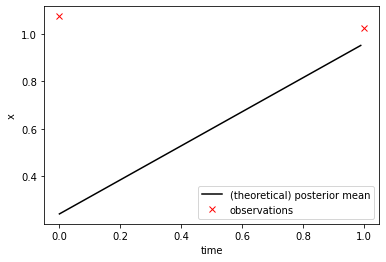

In [47]:
plt.plot(true_sde_pts[:100], compute_mean(true_sde_pts)[:100], color='black', label="(theoretical) posterior mean")
plt.plot(true_sde_pts[::100][:2], obs[:2], 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

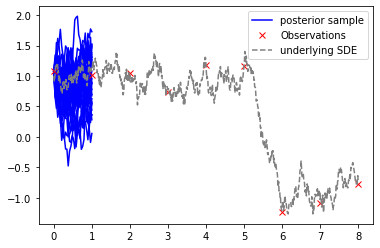

In [57]:
S = 30
posterior = tOU_vector(t0 = obs_time[0], t1 = obs_time[1], z0 = z0, m0 = m0_D, alpha = alpha_, beta = beta_D, sigma = 1, r = r_, D = S, dN = 30, timegrid='True')
plt.plot(posterior.pts.T, posterior.trj.T, 'b')
plt.plot(posterior.pts.T[0], posterior.trj.T[0], 'b', label="posterior sample")
plt.plot(obs_time, obs, 'rx', label='Observations')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed', label="underlying SDE")
plt.legend()
plt.show()

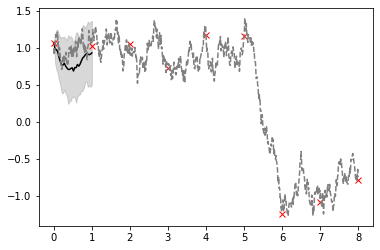

In [58]:
post_mean = torch.mean(posterior.trj, axis=0)
post_std = torch.std(posterior.trj, axis=0)

plt.plot(posterior.pts[0], post_mean, color='black')
plt.fill_between(posterior.pts[0], post_mean + post_std, post_mean - post_std, color='grey', alpha=0.3)
plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed')

**Trace plot: parameters**

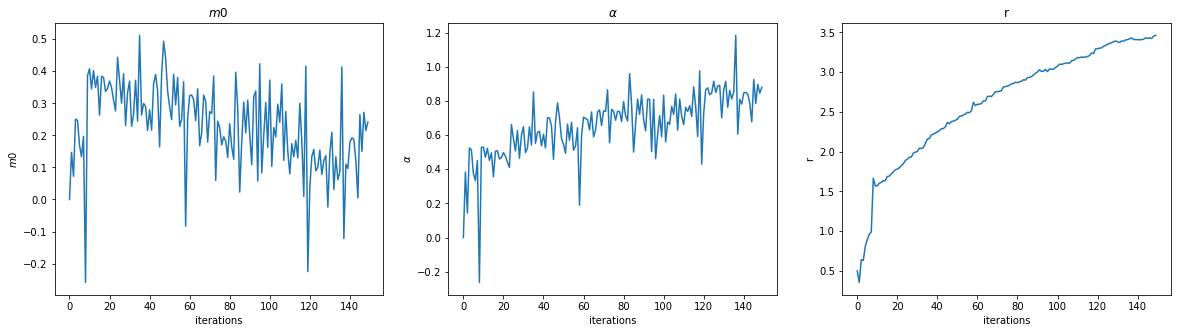

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
names = [r'$m0$', r'$\alpha$', 'r']
for i, ax in enumerate(ax.ravel()):
    par = [item[i].data.numpy() for item in trace_pars]
    ax.plot(np.arange(len(par)), par)
    ax.set_title(names[i])
    ax.set_xlabel('iterations')
    ax.set_ylabel(names[i])
# plt.title("Trace plot: beta")
# plt.plot(np.arange(len(betas)), betas)
# plt.xlabel("iteration")
# plt.ylabel(r"$\beta$")
# plt.show()

**Trace plot: ELBO**

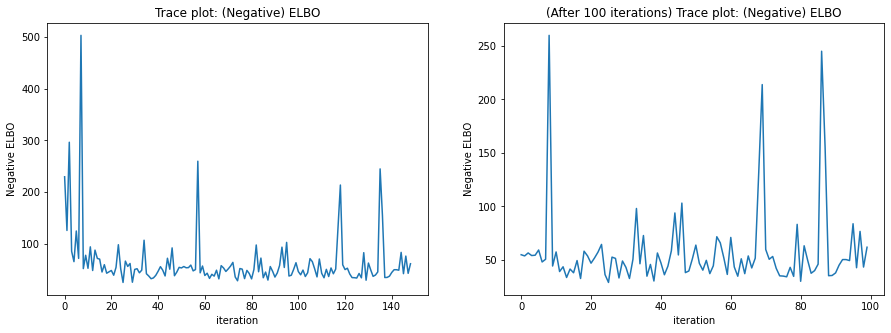

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, ax in enumerate(ax.ravel()):
    ax.set_title("Trace plot: (Negative) ELBO")
    if i == 0:
        ax.plot(np.arange(len(trace_elbo[1:])), trace_elbo[1:])
    else:
        ax.plot(np.arange(len(trace_elbo[50:])), trace_elbo[50:])
        ax.set_title("(After 100 iterations) Trace plot: (Negative) ELBO")
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO")
plt.show()

**Posterior credible interval (constructed by monte carlo estimator based on sample from time-depenent OU with fitted variational parameters**

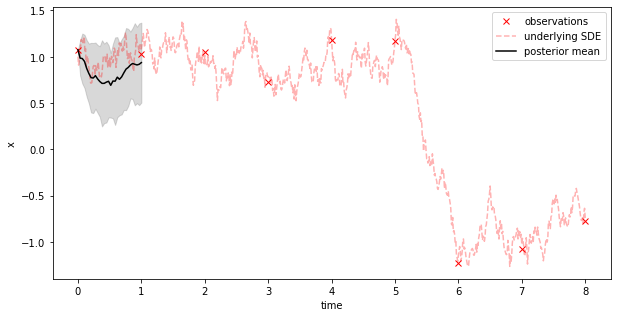

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde_pts,true_sde_trj, 'red', linestyle='dashed', alpha= 0.3, label='underlying SDE')
plt.plot(posterior.pts[0], post_mean, color='black', label="posterior mean")
plt.fill_between(posterior.pts[0], post_mean - post_std, post_mean + post_std, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [104]:
D = 100
S = 50
learning_rate = 0.00005
lr = learning_rate
IT = 250
dN = 30
z0 = obs[0]

beta_D = torch.tensor([1.]).repeat(D, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
NLL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    r_ = torch.rand(1)
    m0_ = torch.rand(1)
    
    i = 0
    conv = 1
    while (conv > 0.00005) and (i < IT): 
        alpha_D = alpha_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        m0_D = m0_.repeat(D, 1)
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=dN, D=D, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_ito() + elbo_.KL_rest()
            NLL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + NLL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            NLL_traces[t, i-1] = torch.mean(NLL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=dN, D=D, timegrid = 'False')
        elbo = ELBO(vi)
        score = Score(vi)

        scores = score.compute_score(alpha_D, beta_D, m0_D, r_D)
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        m0_grad = torch.nanmean(f_of_X * scores['m0'])
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        r_grad = torch.nanmean(f_of_X * scores['r'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter

        m0_ -= learning_rate * m0_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = m0_.clone()
        pars_traces[2, t, i] = r_.clone()

        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "m0 = ", m0_.data.numpy(), "r = ", r_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU_vector(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = m0_[0].repeat(S, 1), alpha = alpha_, beta = beta_D[0], sigma = sde_sigma, r = r_, D = S, dN = dN, timegrid='True')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [-0.00580159] m0 =  [0.9128007] r =  [0.86525226]
(Neg) elbo =  115.81790990394217
alpha =  [-0.03354371] m0 =  [0.8823904] r =  [1.0537487]
(Neg) elbo =  61.45418575579001
alpha =  [-0.01003675] m0 =  [0.8848125] r =  [1.1906016]
(Neg) elbo =  84.16247087547814
alpha =  [-0.01251184] m0 =  [0.86848366] r =  [1.3284371]
(Neg) elbo =  73.32186627034254
alpha =  [0.01495085] m0 =  [0.87598884] r =  [1.4246331]
(Neg) elbo =  63.15210428577506


 12%|█████▋                                       | 1/8 [00:13<01:31, 13.01s/it]

alpha =  [0.00095417] m0 =  [0.422552] r =  [0.0795953]
(Neg) elbo =  165.0131671580767
alpha =  [0.06726833] m0 =  [0.43669048] r =  [0.46390438]
(Neg) elbo =  109.3737011229297
alpha =  [0.15873905] m0 =  [0.46233705] r =  [0.711443]
(Neg) elbo =  99.7191145438309
alpha =  [0.19044341] m0 =  [0.47114965] r =  [0.92217976]
(Neg) elbo =  76.21243987649966
alpha =  [0.20745465] m0 =  [0.47298378] r =  [1.085045]
(Neg) elbo =  81.61398149462077


 25%|███████████▎                                 | 2/8 [00:25<01:17, 12.93s/it]

alpha =  [-0.00354996] m0 =  [0.29940683] r =  [0.18838947]
(Neg) elbo =  167.00513548684773
alpha =  [-0.00589436] m0 =  [0.3013706] r =  [0.5555184]
(Neg) elbo =  111.05780200985217
alpha =  [0.03358031] m0 =  [0.30905247] r =  [0.754766]
(Neg) elbo =  104.00345817714809
alpha =  [0.06914522] m0 =  [0.31680384] r =  [0.9356608]
(Neg) elbo =  78.68166357020142
alpha =  [0.0751087] m0 =  [0.31689072] r =  [1.0764436]
(Neg) elbo =  72.08591313058409


 38%|████████████████▉                            | 3/8 [00:38<01:04, 12.86s/it]

alpha =  [0.01246975] m0 =  [0.9935833] r =  [0.8687634]
(Neg) elbo =  101.11543656031112
alpha =  [0.04347593] m0 =  [0.9980749] r =  [1.0304534]
(Neg) elbo =  91.0242638718553
alpha =  [0.06034984] m0 =  [0.9970238] r =  [1.1877419]
(Neg) elbo =  75.78845423140275
alpha =  [0.05258391] m0 =  [0.9901191] r =  [1.3361534]
(Neg) elbo =  63.89524903060915
alpha =  [0.03412776] m0 =  [0.9821766] r =  [1.4525235]
(Neg) elbo =  72.17962583056787


 50%|██████████████████████▌                      | 4/8 [00:51<00:51, 12.84s/it]

alpha =  [0.05829919] m0 =  [0.11486249] r =  [0.8694678]
(Neg) elbo =  129.04340405167278
alpha =  [0.1462189] m0 =  [0.12622482] r =  [1.0416467]
(Neg) elbo =  75.41213054669441
alpha =  [0.17263834] m0 =  [0.12595934] r =  [1.2195266]
(Neg) elbo =  78.26117726136776
alpha =  [0.16035385] m0 =  [0.11891098] r =  [1.3628902]
(Neg) elbo =  69.00464418252444
alpha =  [0.16612226] m0 =  [0.11302048] r =  [1.4861728]
(Neg) elbo =  79.38145053398706


 62%|████████████████████████████▏                | 5/8 [01:04<00:38, 12.87s/it]

alpha =  [-0.2097411] m0 =  [0.8664809] r =  [0.3232762]
(Neg) elbo =  1171.330678724231
alpha =  [-0.58261055] m0 =  [0.822171] r =  [0.73363495]
(Neg) elbo =  141.8387071926745
alpha =  [-0.5454035] m0 =  [0.8289571] r =  [0.8852354]
(Neg) elbo =  120.68533165859407
alpha =  [-0.49991167] m0 =  [0.8368247] r =  [1.0120093]
(Neg) elbo =  73.83821363201619
alpha =  [-0.44850418] m0 =  [0.8452603] r =  [1.1261348]
(Neg) elbo =  99.32755516101453


 75%|█████████████████████████████████▊           | 6/8 [01:17<00:25, 12.89s/it]

alpha =  [0.00314777] m0 =  [0.20024256] r =  [0.2775793]
(Neg) elbo =  150.6081656501033
alpha =  [-0.1078471] m0 =  [0.18975016] r =  [0.57685214]
(Neg) elbo =  101.74895892255317
alpha =  [-0.13723889] m0 =  [0.18820013] r =  [0.7833972]
(Neg) elbo =  122.26212149436762
alpha =  [-0.13750431] m0 =  [0.19097623] r =  [0.96061856]
(Neg) elbo =  96.23036112732086
alpha =  [-0.1562638] m0 =  [0.19178343] r =  [1.1272187]
(Neg) elbo =  72.07152552611062


 88%|███████████████████████████████████████▍     | 7/8 [01:30<00:12, 12.93s/it]

alpha =  [-0.04497812] m0 =  [0.56552976] r =  [0.4950215]
(Neg) elbo =  154.84243947642423
alpha =  [-0.04617307] m0 =  [0.566737] r =  [0.7491432]
(Neg) elbo =  108.84916356474943
alpha =  [-0.16043675] m0 =  [0.55514354] r =  [0.92310834]
(Neg) elbo =  84.19077507309996
alpha =  [-0.14071482] m0 =  [0.55851287] r =  [1.0536728]
(Neg) elbo =  67.30889247761331
alpha =  [-0.160802] m0 =  [0.557514] r =  [1.1791669]
(Neg) elbo =  95.10866838134771


100%|█████████████████████████████████████████████| 8/8 [01:43<00:00, 12.90s/it]


Trace plot: ELBO

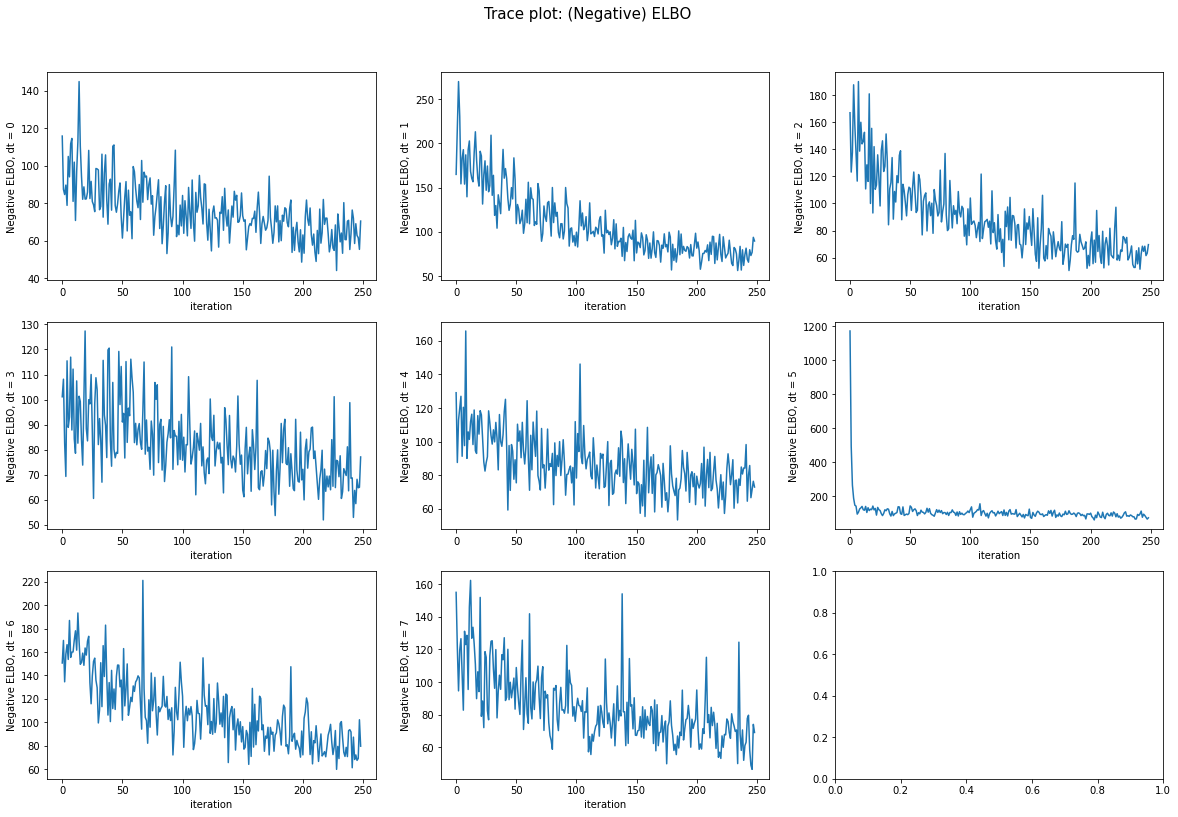

In [105]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

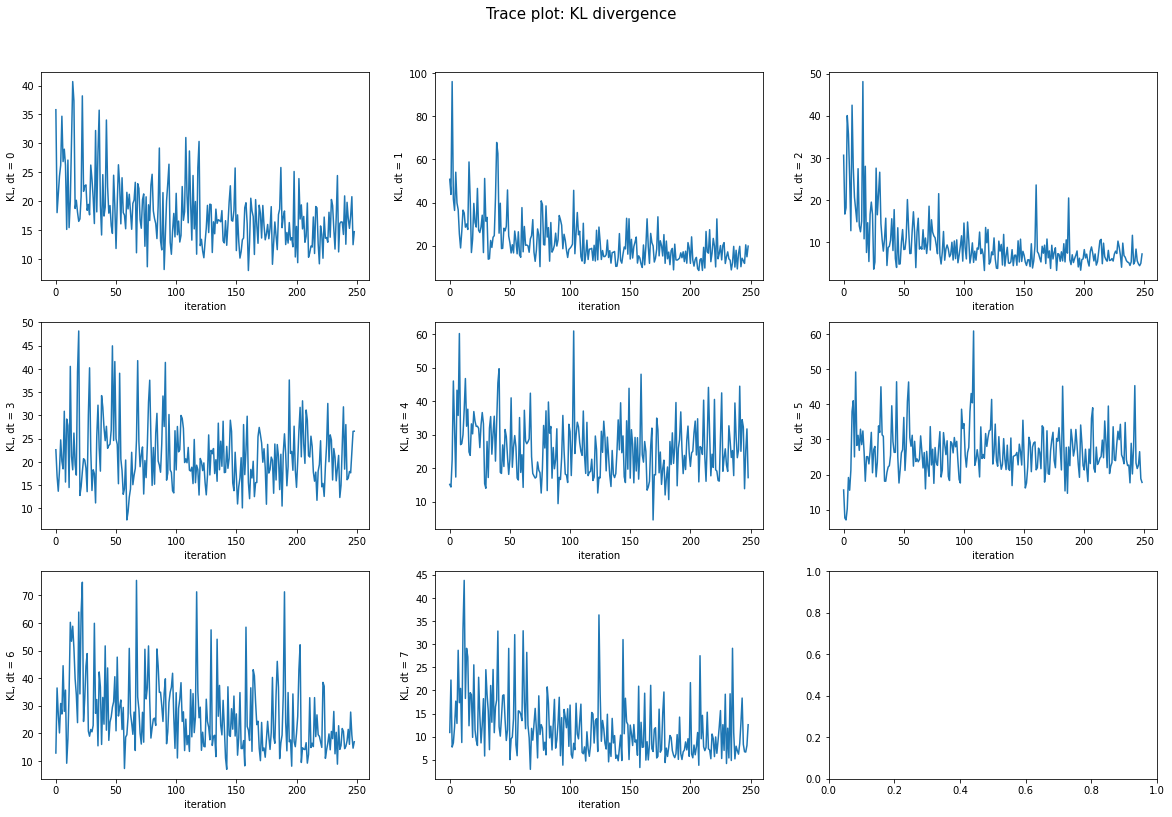

In [107]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

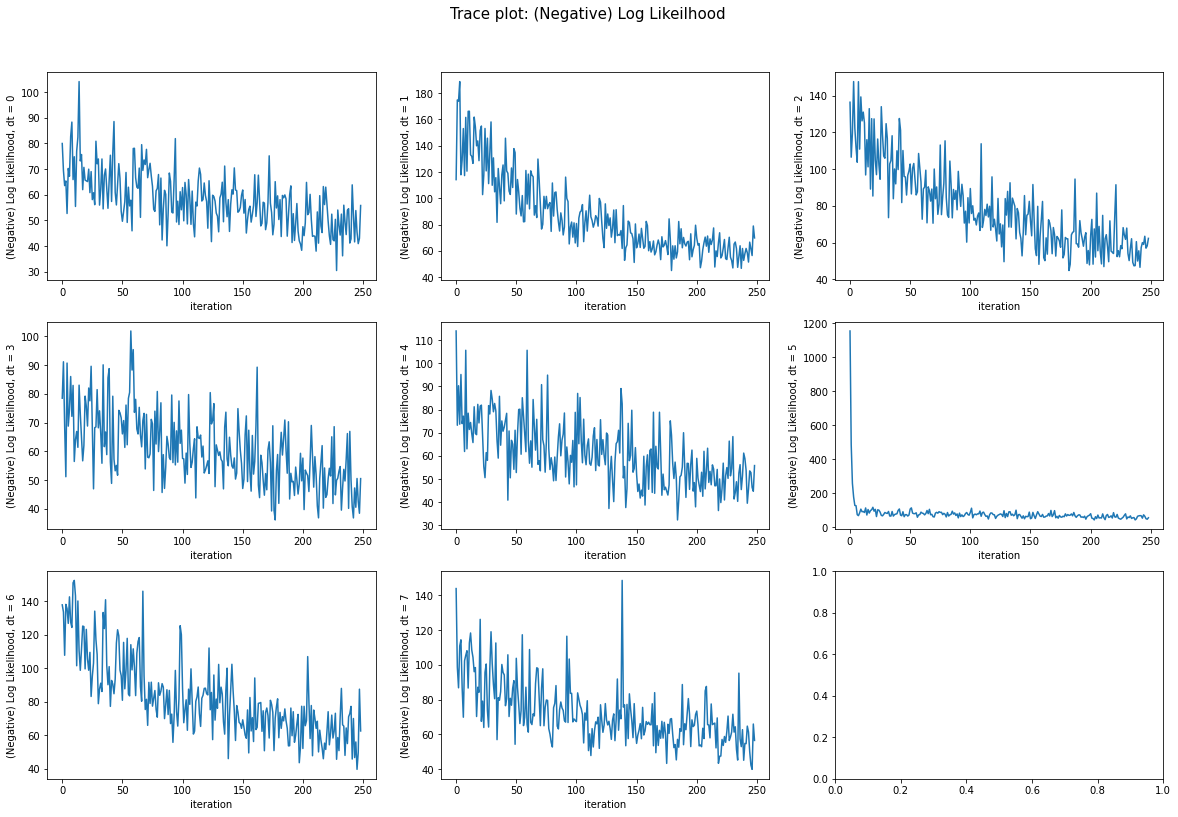

In [109]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(NLL_traces[t, :])), -1 * NLL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

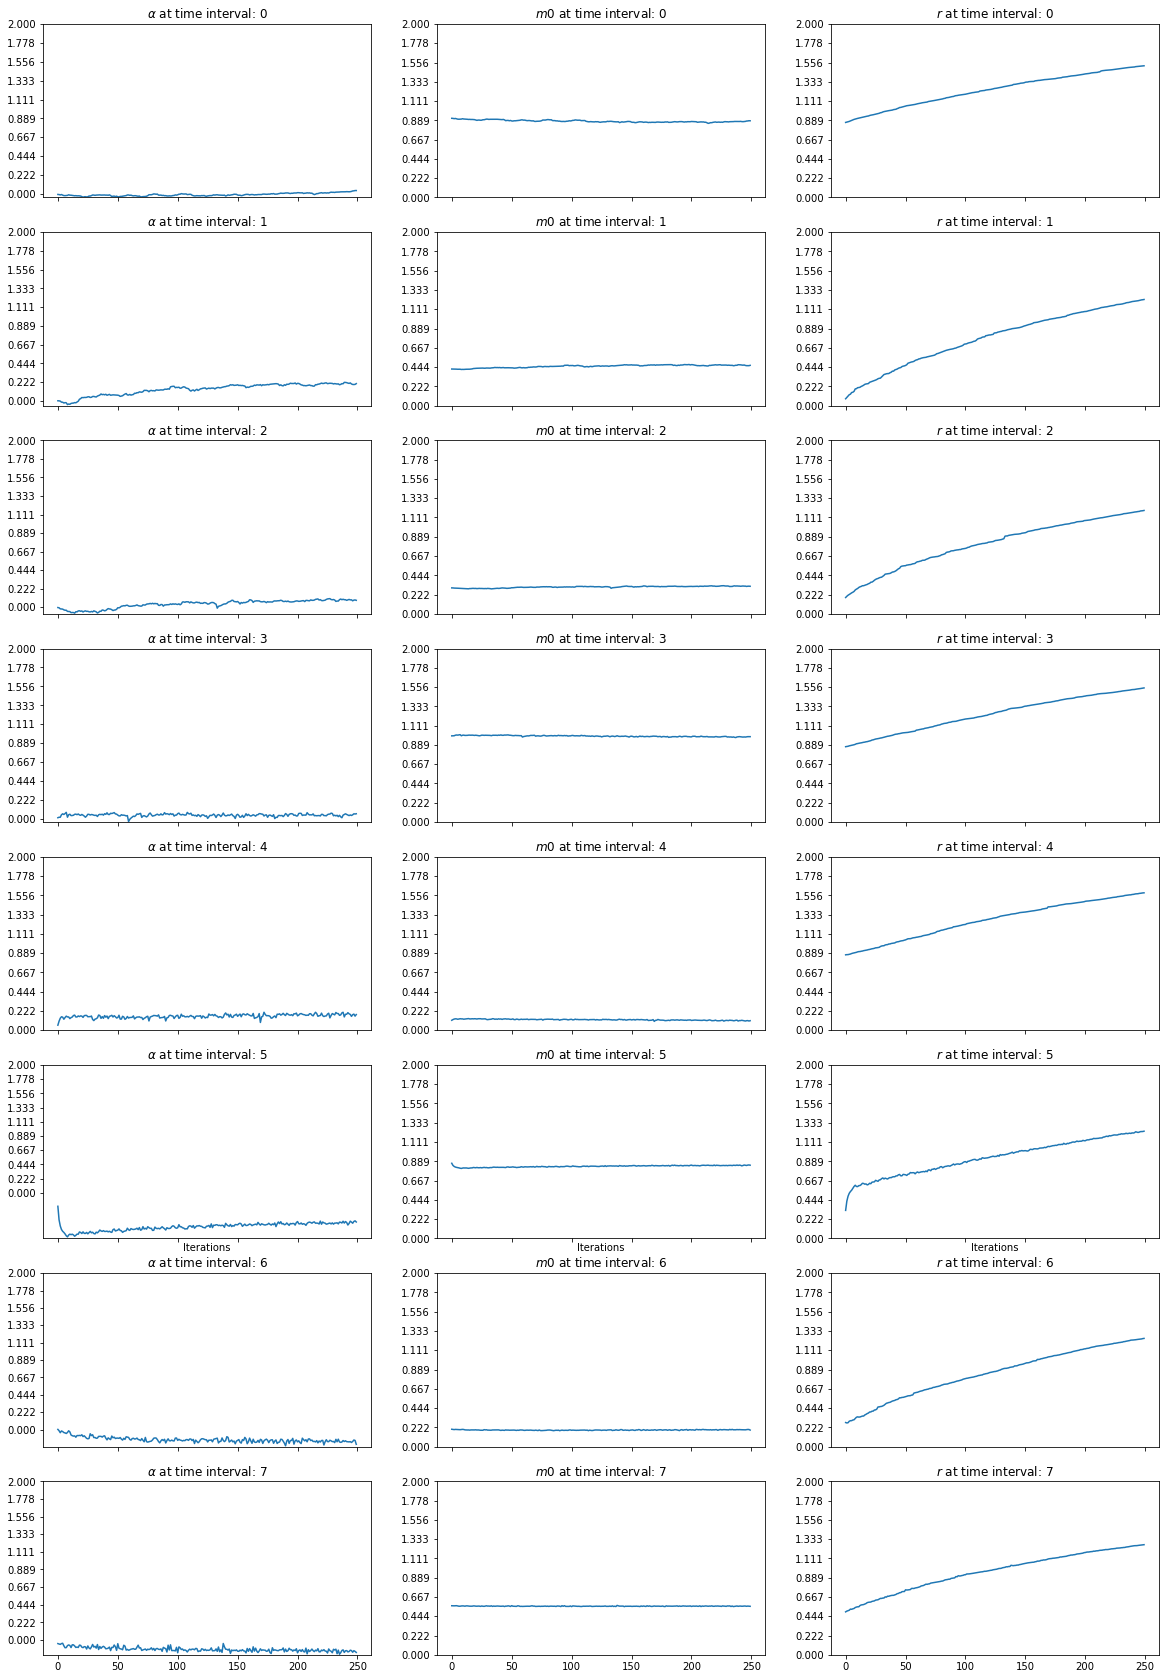

In [110]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$m0$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
    ax.set_yticks(np.linspace(0,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

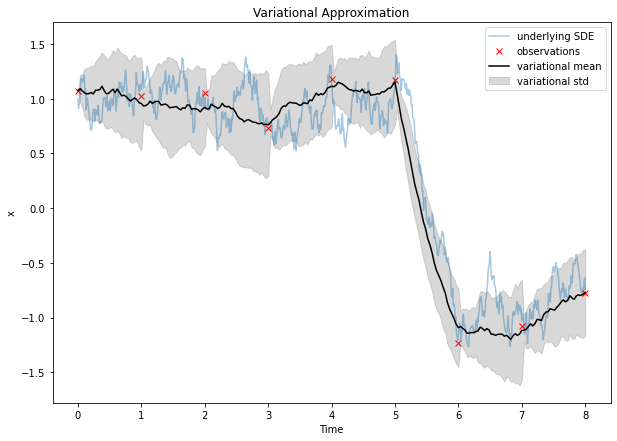

In [111]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde_pts, true_sde_trj, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(np.linspace(0, 8, vi_mean.shape[0]), vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation")
plt.show()